In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import datetime
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV

import matplotlib.pyplot as plt

In [30]:
data = pd.read_csv("/content/drive/MyDrive/CODINGML/final_dataset_stocks.csv")
data.head()

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


In [31]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [32]:
#The rows with NaN are days when market was closed. I will be deleting those rows.
data.dropna(inplace=True)
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


In [33]:
data.select_dtypes(include=[object])
data.drop(columns=['SP_Volume'], inplace=True)

In [34]:
#Replacing values in yield_curves
for i in range(len(data)):
  if data.iloc[i,-1] == '.':
    data.iloc[i,-1] = data.iloc[i + 1,-1] 

In [35]:
#Replacing values in interest rate
for i in range(len(data)):
  if data.iloc[i,16] == '.':
    data.iloc[i,16] = data.iloc[i + 1,16] 

In [36]:
#Converting the above columns into float
data['yield_rate'] = data['yield_rate'].astype('float')
data['interest_rate'] = data['interest_rate'].astype('float')

In [37]:
#Finally lets convert date string to datetime format
# for i in range(len(data)):
#   data.iloc[i,0] = datetime.datetime.strptime(data.iloc[i,0], '%Y-%m-%d')

data['date'] = pd.to_numeric(pd.to_datetime(data['date']))
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,1325548800000000000,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,1325635200000000000,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,1325721600000000000,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,1325808000000000000,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,1326067200000000000,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,1277.83,1281.99,1274.55,2.11,16068.824,1.98


In [10]:
# from sklearn import preprocessing
# import pandas as pd
# d = preprocessing.normalize(data, axis=0)
# scaled_df = pd.DataFrame(d)
# scaled_df.columns = ['date', 'IBM_open', 'IBM_high','IBM_low','IBM_close','IBM_volume','NASDAQ_open','NASDAQ_high',	'NASDAQ_low',
#                      'NASDAQ_close','NASDAQ_Adj_close',	'NASDAQ_volume','SP_close',	'SP_Open','SP_High','SP_low','interest_rate','gdp','yield_rate']
# scaled_df.head()

In [38]:
X = data.drop(columns =['IBM_close'])
y = data.IBM_close.values
# X = scaled_df.drop(columns =['IBM_close'])
# y = scaled_df.IBM_close.values
#X, y = np.array(X), np.array(y)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [40]:
#LINEAR REGRESSION MODEL
model = LinearRegression().fit(X_train, y_train)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cvsc = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#scores = np.absolute(scores)
print((np.mean(cvsc), np.std(cvsc)))

#predicted y values
y_pred = model.predict(X_test)



(-61.3399989391553, 5.607990766325784)


In [41]:
from sklearn.metrics import mean_squared_error
rmse_linear = np.sqrt(mean_squared_error(y_test,y_pred))
print(rmse_linear)

8.210528111281475


In [42]:
#parameter tuning
# define model
ridgemodelalpha = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(ridgemodelalpha, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train,y_train)
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MSE: -0.180
Config: {'alpha': 0.99}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.11334e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [43]:
#RIDGE REGRESSION
#can also test around with the alpha value, currently set to the default 1
ridgemodel = Ridge(alpha=0.99,normalize=True)

#k=5 or 10 is very common that generally result in a model skill estimate with low bias a modest variance
#can change this later
#repeat this process 3 times to get an average 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#evaluate the model
scores = cross_val_score(ridgemodel, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
ridgemodel.fit(X_train,y_train)
y_pred2 = ridgemodel.predict(X_test)
#print(y_pred2)
# summarize chosen configuration
#print('alpha: %f' % model.alpha_)

(8.148292801301011, 0.7290834613771418)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [44]:
rmse_ridge = np.sqrt(mean_squared_error(y_test,y_pred2))
print(rmse_ridge)

2.8842393028989712


In [18]:
#parameter tuning
# define model
lassomodelalpha = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(lassomodelalpha, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train,y_train)
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


MSE: -0.254
Config: {'alpha': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+02, tolerance: 2.309e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [45]:
#LASSO REGRESSION
#can also test around with the alpha value, currently set to the default 1
lassomodel = Lasso(alpha=0.01,normalize=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lassomodel, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
lassomodel.fit(X_train,y_train)
y_pred3 = lassomodel.predict(X_test)
#print(y_pred3)

(0.6166344849444207, 0.0883093563481063)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [46]:
rmse_lasso = np.sqrt(mean_squared_error(y_test,y_pred3))
print(rmse_lasso)

0.7515301036817973


In [21]:
#parameter tuning
# define model
elasticmodelalpha = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(elasticmodelalpha, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train,y_train)
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define model
# ratios = arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# elasticmodelalpha = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# # fit model
# elasticmodelalpha.fit(X_train,y_train)
# # summarize chosen configuration
# print('alpha: %f' % elasticmodelalpha.alpha_)
# print('l1_ratio_: %f' % elasticmodelalpha.l1_ratio_)

MSE: -0.254
Config: {'alpha': 0.01, 'l1_ratio': 0.56}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e+02, tolerance: 2.309e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [47]:
#ELASTIC NET REGRESSION
elasticmodel = ElasticNet(alpha=0.01, l1_ratio=0.56,normalize=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(elasticmodel, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
elasticmodel.fit(X_train,y_train)
y_pred4 = elasticmodel.predict(X_test)
#print(y_pred4)

(57.055323872564045, 4.589166603304194)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


In [48]:
rmse_elastic = np.sqrt(mean_squared_error(y_test,y_pred4))
print(rmse_elastic)

7.6975612532612745


In [49]:
#this converts the numeric date back to datetime (just to make the graph prettier)
#this is for actual date
for i in range(len(data)):
  your_timestamp = data.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  data.iloc[i,0] = date.date()
data.date = pd.to_datetime(data['date'])

#this is for the X_test
for i in range(len(X_test)):
  your_timestamp = X_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  X_test.iloc[i,0] = date.date()
X_test.date = pd.to_datetime(X_test['date'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


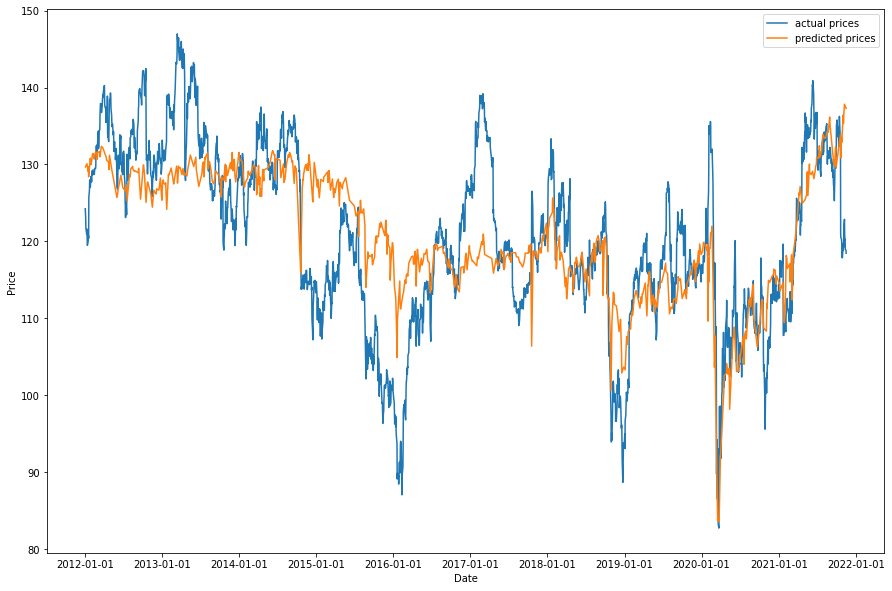

In [50]:
#plots
# this increases the figure size for added viewability
from pylab import rcParams
from matplotlib.dates import DateFormatter
rcParams['figure.figsize'] = 15, 10

#plots the linear regression model
plt.plot(data['date'],y, label ="actual prices")
ax = sns.lineplot(X_test['date'],y_pred, label ="predicted prices")

date_form = DateFormatter("20%y-%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


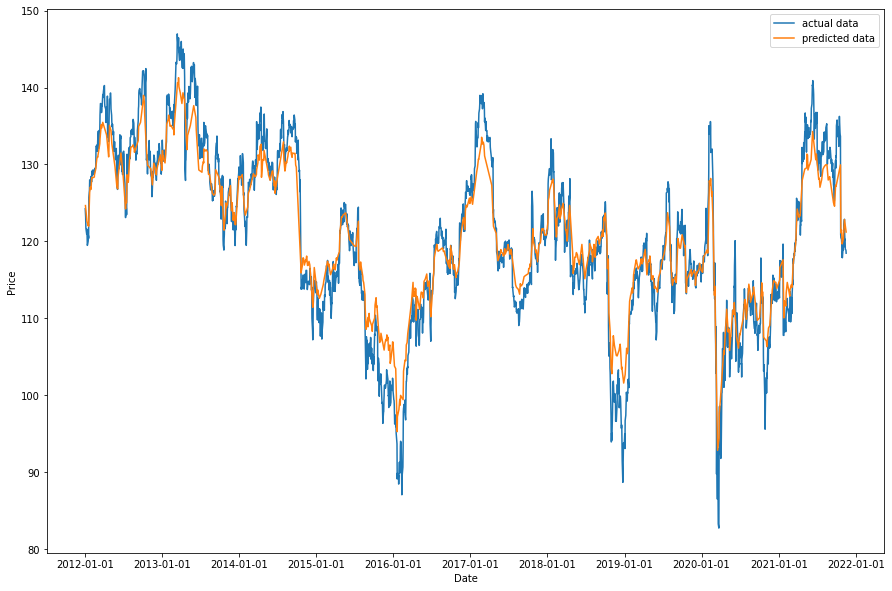

In [51]:
#plots the ridge regression model
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test['date'],y_pred2, label ="predicted data")

date_form = DateFormatter("20%y-%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


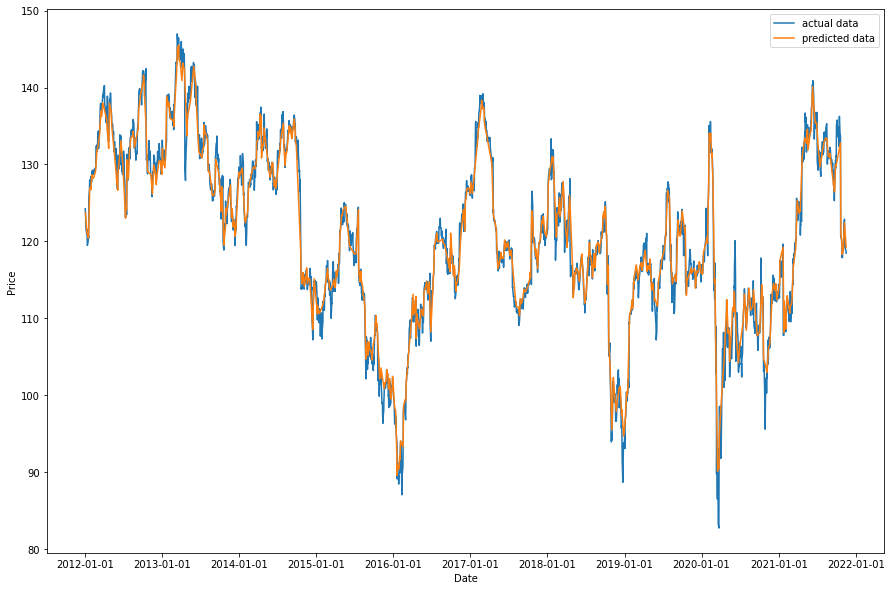

In [52]:
#plots the lasso regression model
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test['date'],y_pred3, label ="predicted data")

date_form = DateFormatter("20%y-%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


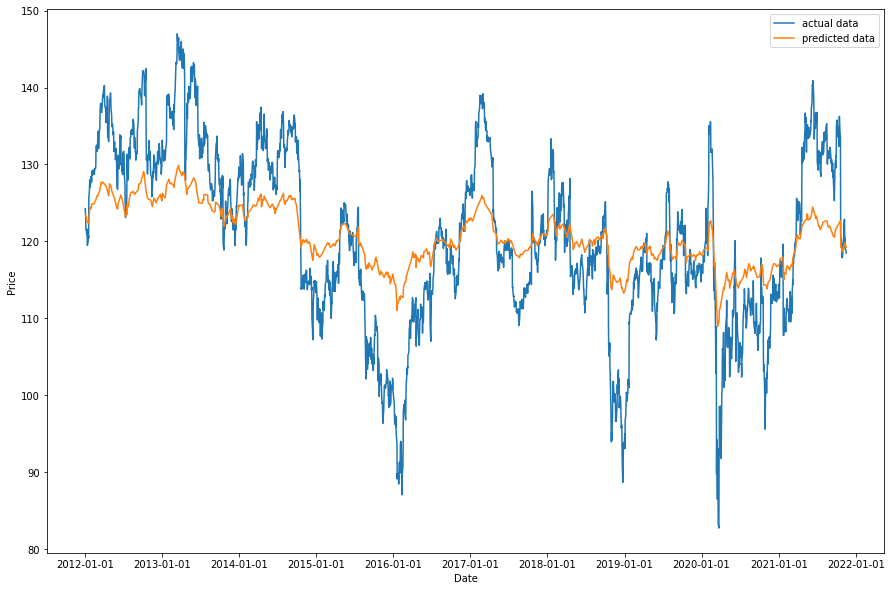

In [53]:
#plots the elastic net regression model
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test['date'],y_pred4, label ="predicted data")

date_form = DateFormatter("20%y-%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
